In [ ]:
import os
# will need to add gene names for peaks later
!perl ~/homer/configureHomer.pl -install mm10
os.environ['PATH'] += os.pathsep + '/Users/jeongveen/homer/bin'

In [ ]:
# Prepare active L1 data from L1base2 & make chrX file separately

!grep -i chrX ./L1_data/L1base_active.bed > ./L1_data/L1active_chrX.bed
#!wc -l ./L1_data/L1active_chrX.bed -> 288

wc: ./L1_data/clip_in_L1.bed: open: No such file or directory


In [ ]:
# Used PAR-CLIP tolerant bwa-parclip for SRR7798821.fastq

!python bwa-parclip/bwaparclip.py --reference ref_genome/mm10.fa clip_data/SRR7798821.fastq --read-group $'@RG\\tID:foo\\tSM:bar' --threads 16 --prefix smchd1

/Users/jeongveen/Documents/smchd1_parclip_study/bwa-parclip/bwaparclip.py:236: SyntaxWarning: invalid escape sequence '\d'
  def longest_match(self, patt=re.compile("\d+M")):
running: bwa mem -T 40 -B 2 -L 10 -CM -R '@RG\tID:foo\tSM:bar' -t 16  ref_genome/mm10.fa.bwaparclip.t2c '</Users/jeongveen/miniconda3/envs/bioenv/bin/python /Users/jeongveen/Documents/smchd1_parclip_study/bwa-parclip/bwaparclip.py t2c clip_data/SRR7798821.fastq NA'
writing to:
samtools view -bS - | samtools sort -m 2415919104 - smchd1
[M::bwa_idx_load_from_disk] read 0 ALT contigs
/Users/jeongveen/Documents/smchd1_parclip_study/bwa-parclip/bwaparclip.py:236: SyntaxWarning: invalid escape sequence '\d'
  def longest_match(self, patt=re.compile("\d+M")):
converting reads in clip_data/SRR7798821.fastq,NA
[M::process] read 2116954 sequences (160000070 bp)...
[M::process] read 2116960 sequences (160000084 bp)...
[M::mem_process_seqs] Processed 2116954 reads in 941.873 CPU sec, 98.237 real sec
[M::process] read 2116956 

In [ ]:
#!samtools faidx ref_genome/mm10.fa
'''
bash
%(
  echo -e "@HD\tVN:1.6\tSO:unsorted"
  awk '{print "@SQ\tSN:"$1"\tLN:"$2}' ref_genome/mm10.fa.fai
  echo -e "@PG\tID:bwa-parclip\tPN:bwa-parclip\tVN:1.0.0\tCL:\"bwa mem ...\""
  grep -v '^@' aligned_only.sam
) > aligns.sam
'''
#Align and sort bam file
#!samtools view -bS aligns.sam > smchd1_align.bam
!samtools sort smchd1_align.bam -o smchd1_align.sorted.bam
!samtools index smchd1_align.sorted.bam

[bam_sort_core] merging from 16 files and 1 in-memory blocks...


In [ ]:
### Find reads with high depth and T -> C substitution for analysis

#!samtools mpileup -f ref_genome/mm10.fa smchd1_align.sorted.bam > smchd1.pileup
#!samtools view ./smchd1_align.sorted.bam chrX | grep "MD:Z:" | head

#!awk '$4 > 5 && $5 ~ /[acgtnACGTN]/' smchd1.pileup > high_mismatch.txt
#!awk 'toupper($3) == "T" && $5 ~ /[cC]/ && $4 > 50' smchd1.pileup > high_mismatch.txt
'''
in console
awk 'toupper($3) == "T" {
    c = gsub(/[cC]/, "", $5);  # count T→C mismatches
    total = $4;
    if (total >= 10 && c > 0) {
        rate = c / total;
        if (rate > 0.5) {
            print $1, $2, $3, total, c, rate;
        }
    }
}' high_mismatch.txt > high_mismatch2.txt
'''
!awk 'BEGIN{OFS="\t"} {print $1, $2 - 1, $2, $6}' high_mismatch2.txt > high_mismatch.bed


### Use Active L1 database to search if there is Line1-smchd1 interaction
!bedtools intersect -a high_mismatch.bed -b ./L1_data/L1base_active.bed -wa -wb > tc_in_L1s.bed

Sadly, no peaks at chrX L1s.

chr18	15988666	15988667	1	chr18	15978401	15988799	UID-514	0	+	15982605	15987604	128,128,128
chr2	159653354	159653355	1	chr2	159652788	159663187	UID-1639	0	+	159656992	159661991	128,128,128
chr2	159653377	159653378	1	chr2	159652788	159663187	UID-1639	0	+	159656992	159661991	128,128,128
chr2	159653380	159653381	1	chr2	159652788	159663187	UID-1639	0	+	159656992	159661991	128,128,128
chr2	159653383	159653384	1	chr2	159652788	159663187	UID-1639	0	+	159656992	159661991	128,128,128
chr4	9931312	9931313	1	chr4	9921378	9931775	UID-1570	0	-	9922573	9927530	128,128,128

In [ ]:
# Interesting region
!samtools view smchd1_align.sorted.bam chr2:159653355-159653355

SRR7798821.11075651	0	chr2	159653325	12	7M1D41M2I26M	*	0	0	TTACTTTTGCTTCTTCTACTTCTTTGTTGCTTGTTGTTGTTGTTGTTGAAGTGTCGTCTTCACCCTCTTTTGGTCN	????????????????????????????????????????????????????????????????????????????	NM:i:11	MD:Z:7^A1C2A5C30C20C0C1G0A0	AS:i:43	XS:i:35	RG:Z:foo	XA:Z:rchr16,-16640891,15M1D17M1D44M,14;fchr14,+38652893,17M4D29M5I25M,18;	YC:Z:TC	YD:Z:f
SRR7798821.14872323	0	chr2	159653325	12	7M1D41M2I26M	*	0	0	TTACTTTTGCTTCTTCTACTTCTTTGTTGCTTGTTGTTGTTGTTGTTGAAGTGTCGTCTTCACCCTCTTTTGGTCN	????????????????????????????????????????????????????????????????????????????	NM:i:11	MD:Z:7^A1C2A5C30C20C0C1G0A0	AS:i:43	XS:i:35	RG:Z:foo	XA:Z:rchr16,-16640891,15M1D17M1D44M,14;fchr14,+38652893,17M4D29M5I25M,18;	YC:Z:TC	YD:Z:f
SRR7798821.24253254	0	chr2	159653325	0	7M1D41M2I26M	*	0	0	GTACTTTTGCTTCTTCTACTTCTTTGTTGCTTGTTGTTGTTGTTGTTGAAGTGTCGTCTTCACCCTCGTTTGGTCN	????????????????????????????????????????????????????????????????????????????	NM:i:13	MD:Z:0C6^A1C2A5C30C16C3C0C1G0A0	AS:i:40	XS:i:36	RG:Z:f

In [57]:
!awk '$1 == "chr2" && $2 >= 159653345 && $2 <= 159653392 { print $0; }' smchd1.pileup > chr2L1-smchd1.pileup

import numpy as np
from collections import Counter
import re

#1/2
LS  = pd.read_csv('chr2L1-smchd1.pileup', sep="\t", names=['chrom', 'pos', '_ref', 'count', 'basereads', 'quals'])
cleaned = re.compile(r'\^.|[<>$*#^]')
LS['matches2'] = LS['basereads'].apply(lambda x: cleaned.sub('', x))

# Function to compute entropy
def shannon_entropy(seq):
    counts = Counter(seq.upper())
    total = sum(counts.values())
    if total == 0:
        return 0
    probs = [count / total for count in counts.values()]
    return -sum(p * np.log2(p) for p in probs if p > 0)

LS['entropy'] = LS['matches2'].apply(shannon_entropy)

#3
# Convert to BEDGRAPH format
LS['start'] = LS['pos'] - 1  # BEDGRAPH is 0-based
LS['end'] = LS['pos']      # 1-based end our base length is one
bedgraphls= LS[['chrom', 'start', 'end', 'entropy']]

# Save to file
bedgraphls.to_csv('ls_entropy.bedgraph', sep="\t", header=False, index=False)

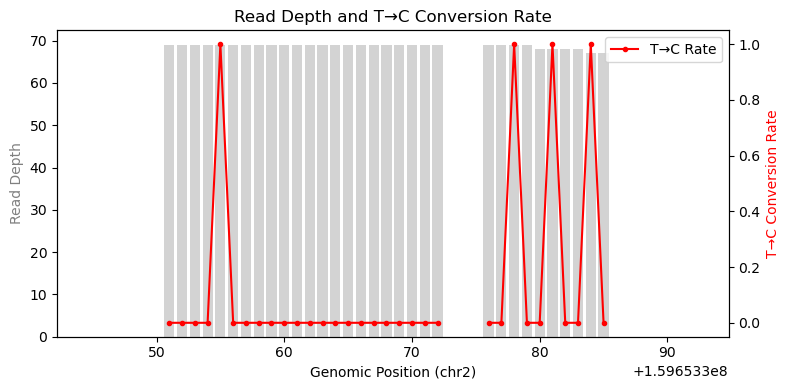

In [58]:
# Load pileup data
df = pd.read_csv('chr2L1-smchd1.pileup', sep='\t', 
                 names=['chrom', 'pos', 'ref', 'depth', 'bases', 'qual'])

# Calculate T->C conversion rate
df['t_to_c_count'] = df['bases'].str.count('[cC]')
df['t_to_c_rate'] = df['t_to_c_count'] / df['depth']

# Plot read depth
fig, ax1 = plt.subplots(figsize=(8, 4))
ax1.bar(df['pos'], df['depth'], color='lightgray', label='Depth')
ax1.set_xlabel('Genomic Position (chr2)')
ax1.set_ylabel('Read Depth', color='gray')

# Overlay T→C conversion rate
ax2 = ax1.twinx()
ax2.plot(df['pos'], df['t_to_c_rate'], 'ro-', label='T→C Rate', markersize=3)
ax2.set_ylabel('T→C Conversion Rate', color='red')

plt.title('Read Depth and T→C Conversion Rate')
plt.tight_layout()
plt.legend(loc='upper right')
plt.show()

In [ ]:
#!awk '$1 == "chr1" && $2 >= 46106013 && $2 <= 46412706 { print $0; }' smchd1.pileup > chr1mRNA-smchd1.pileup
!awk '$1 == "chr9" && $2 >= 3038669 && $2 <= 3038743 { print $0; }' smchd1.pileup > mir101c-smchd1.pileup

import numpy as np
from collections import Counter
import re

#1/2
LS  = pd.read_csv('chr1mRNA-smchd1.pileup', sep="\t", names=['chrom', 'pos', '_ref', 'count', 'basereads', 'quals'])
cleaned = re.compile(r'\^.|[<>$*#^]')
LS['matches2'] = LS['basereads'].apply(lambda x: cleaned.sub('', x))

# Function to compute entropy
def shannon_entropy(seq):
    counts = Counter(seq.upper())
    total = sum(counts.values())
    if total == 0:
        return 0
    probs = [count / total for count in counts.values()]
    return -sum(p * np.log2(p) for p in probs if p > 0)

LS['entropy'] = LS['matches2'].apply(shannon_entropy)

#3
# Convert to BEDGRAPH format
LS['start'] = LS['pos'] - 1  # BEDGRAPH is 0-based
LS['end'] = LS['pos']      # 1-based end our base length is one
bedgraphls= LS[['chrom', 'start', 'end', 'entropy']]

# Save to file
bedgraphls.to_csv('ls_entropy.bedgraph', sep="\t", header=False, index=False)

# Calculate T->C conversion rate
LS['t_to_c_count'] = LS['basereads'].str.count('[cC]')
LS['t_to_c_rate'] = LS['t_to_c_count'] / LS['count']

import numpy as np

# Normalize T→C rate and entropy to [0, 1]
LS['t_to_c_rate_norm'] = LS['t_to_c_rate'] / LS['t_to_c_rate'].max()
LS['entropy_norm'] = LS['entropy'] / LS['entropy'].max()

fig, ax1 = plt.subplots(figsize=(10, 4))

# Read depth (left y-axis)
ax1.bar(LS['pos'], LS['count'], color='lightgray', label='Read Depth', width=1)
ax1.set_xlabel('Genomic Position (chr1)')
ax1.set_ylabel('Read Depth', color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.set_ylim(0, LS['count'].max() * 1.2)

# Right y-axis for normalized data
ax2 = ax1.twinx()
ax2.plot(LS['pos'], LS['t_to_c_rate'], 'r-', label='T→C Rate (normalized)', linewidth=2)
ax2.plot(LS['pos'], LS['entropy_norm'], 'b--', label='Entropy (normalized)', linewidth=2)
ax2.set_ylabel('Normalized T→C Rate & Entropy', color='black')
ax2.tick_params(axis='y', labelcolor='black')
ax2.set_ylim(0, 1.05)

# Combined legend
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper right', fontsize=9)

plt.title('Read Depth with T→C Conversion and Entropy (chr2 region)')
plt.tight_layout()
plt.show()
'''
'''
# Plot read depth
fig, ax1 = plt.subplots(figsize=(8, 4))
ax1.bar(LS['pos'], LS['count'], color='black', label='Depth')
ax1.set_xlabel('Genomic Position (chr2)')
ax1.set_ylabel('Read Depth', color='gray')

# Overlay T→C conversion rate
ax2 = ax1.twinx()
ax2.plot(LS['pos'], LS['t_to_c_rate'], 'ro-', label='T→C Rate', markersize=3)


# Overlay entrophy
ax3 = ax1.twinx()
ax3.plot(LS['pos'], LS['entropy'], 'bo-', label='Shannon', markersize=1)

plt.title('Read Depth and Errors')
plt.tight_layout()
plt.legend(loc='upper right')
plt.show()

<>:11: SyntaxWarning: invalid escape sequence '\^'
<>:11: SyntaxWarning: invalid escape sequence '\^'
/var/folders/h1/19s6l9_x5jxbd53pvfndp83h0000gn/T/ipykernel_40452/1623764912.py:11: SyntaxWarning: invalid escape sequence '\^'
  cleaned = re.compile(r'\^.|[<>$*#^]')


"\n# Plot read depth\nfig, ax1 = plt.subplots(figsize=(8, 4))\nax1.bar(LS['pos'], LS['count'], color='black', label='Depth')\nax1.set_xlabel('Genomic Position (chr2)')\nax1.set_ylabel('Read Depth', color='gray')\n\n# Overlay T→C conversion rate\nax2 = ax1.twinx()\nax2.plot(LS['pos'], LS['t_to_c_rate'], 'ro-', label='T→C Rate', markersize=3)\n\n\n# Overlay entrophy\nax3 = ax1.twinx()\nax3.plot(LS['pos'], LS['entropy'], 'bo-', label='Shannon', markersize=1)\n\nplt.title('Read Depth and Errors')\nplt.tight_layout()\nplt.legend(loc='upper right')\nplt.show()\n"

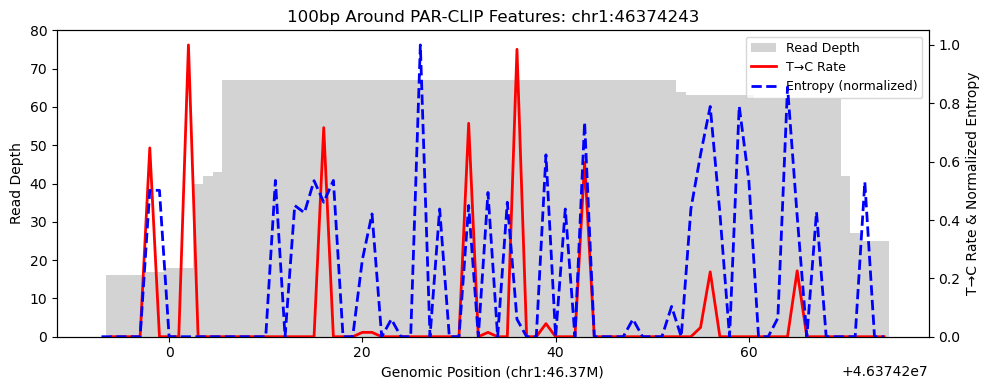

In [ ]:
# Filter to chr2:46106063 peak
region_df = LS[(LS['pos'] >= 46374243-50) & (LS['pos'] <= 46374243+50)].copy()

# Normalize T→C rate and entropy within the region
#region_df['t_to_c_rate_norm'] = region_df['t_to_c_rate'] / region_df['t_to_c_rate'].max()
region_df['entropy_norm'] = region_df['entropy'] / region_df['entropy'].max()

fig, ax1 = plt.subplots(figsize=(10, 4))

# Read depth
ax1.bar(region_df['pos'], region_df['count'], color='lightgray', label='Read Depth', width=1)
ax1.set_xlabel('Genomic Position (chr1:46.37M)')
ax1.set_ylabel('Read Depth', color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.set_ylim(0, 80)

# T→C rate and Entropy (normalized)
ax2 = ax1.twinx()
ax2.plot(region_df['pos'], region_df['t_to_c_rate'], 'r-', label='T→C Rate', linewidth=2)
ax2.plot(region_df['pos'], region_df['entropy_norm'], 'b--', label='Entropy (normalized)', linewidth=2)
ax2.set_ylabel('T→C Rate & Normalized Entropy', color='black')
ax2.tick_params(axis='y', labelcolor='black')
ax2.set_ylim(0, 1.05)

# Combined legend
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper right', fontsize=9)

plt.title('100bp Around PAR-CLIP Features: chr1:46374243')
plt.tight_layout()
plt.show()

In [28]:
#See if there is anything else interesting for mismatched

#!bedtools intersect -abam smchd1_align.sorted.bam -b high_mismatch.bed > selected_reads.bam
#!makeTagDirectory selected_reads_tagDir selected_reads.bam
#!annotatePeaks.pl high_mismatch.bed mm10 -d selected_reads_tagDir > annotated_mismatches.txt
!awk '$NF >= 5' annotated_mismatches.txt > high_support_annotations.txt

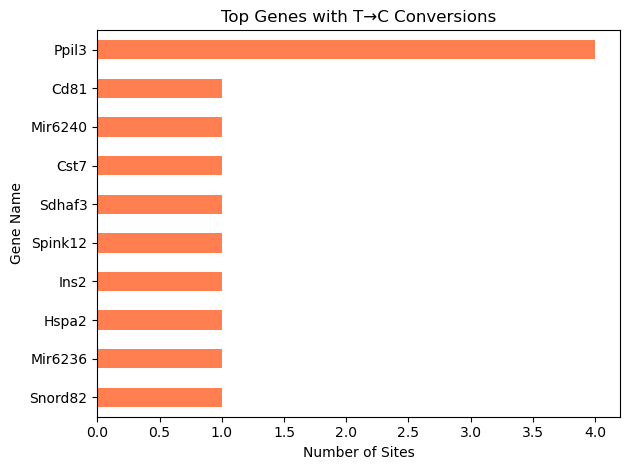

In [18]:
df = pd.read_csv("annotated_mismatches.txt", sep="\t")

df = df[df['Annotation'].str.startswith('pro') == True]
top_genes = df['Gene Name'].value_counts().head(10)
top_genes.plot(kind='barh', color='coral')
plt.title("Top Genes with T→C Conversions")
plt.xlabel("Number of Sites")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [ ]:
#chr2	150569929	150569929	+	0	NA	promoter-TSS (NM_009977)	promoter-TSS (NM_009977)	-486	NM_009977	13011		NM_009977	ENSMUSG00000068129	Cst7	Cmap	cystatin F (leukocystatin)	protein-coding	2426.91
!awk '$1 == "chr1" && $2 >= 58446250 && $2 <= 58446300 { print $0; }' smchd1.pileup > TSS-smchd1.pileup

#1/2
LS  = pd.read_csv('TSS-smchd1.pileup', sep="\t", names=['chrom', 'pos', '_ref', 'count', 'basereads', 'quals'])
cleaned = re.compile(r'\^.|[<>$*#^]')
LS['matches2'] = LS['basereads'].apply(lambda x: cleaned.sub('', x))

# Load your reference genome (FASTA must be indexed or small)
ref = SeqIO.to_dict(SeqIO.parse("/Users/jeongveen/Documents/smchd1_parclip_study/ref_genome/mm10.fa", "fasta"))

# Extract sequence for the region
start, end = 58446250, 58446300
seq_region = str(ref['chr1'].seq[start-1:end-1]).upper()
# Function to compute entropy
def shannon_entropy(seq):
    counts = Counter(seq.upper())
    total = sum(counts.values())
    if total == 0:
        return 0
    probs = [count / total for count in counts.values()]
    return -sum(p * np.log2(p) for p in probs if p > 0)

LS['entropy'] = LS['matches2'].apply(shannon_entropy)

#3
# Convert to BEDGRAPH format
LS['start'] = LS['pos'] - 1  # BEDGRAPH is 0-based
LS['end'] = LS['pos']      # 1-based end our base length is one
bedgraphls= LS[['chrom', 'start', 'end', 'entropy']]

# Save to file
bedgraphls.to_csv('ls_entropy.bedgraph', sep="\t", header=False, index=False)

# Calculate T->C conversion rate
LS['t_to_c_count'] = LS['basereads'].str.count('[cC]')
LS['t_to_c_rate'] = LS['t_to_c_count'] / LS['count']

# Normalize T→C rate and entropy to [0, 1]
LS['t_to_c_rate_norm'] = LS['t_to_c_rate'] / LS['t_to_c_rate'].max()
LS['entropy_norm'] = LS['entropy'] / LS['entropy'].max()

fig, ax1 = plt.subplots(figsize=(12, 5))

# Read depth (left y-axis)
ax1.bar(LS['pos'], LS['count'], color='lightgray', label='Read Depth', width=1)
ax1.set_xlabel('Genomic Position (chr1)')
ax1.set_ylabel('Read Depth', color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.set_ylim(0, 80)

# Right y-axis for normalized data
ax2 = ax1.twinx()
ax2.plot(LS['pos'], LS['t_to_c_rate'], 'r-', label='T→C Rate (normalized)', linewidth=2)
ax2.plot(LS['pos'], LS['entropy_norm'], 'b--', label='Entropy (normalized)', linewidth=2)
ax2.set_ylabel('Normalized T→C Rate & Entropy', color='black')
ax2.tick_params(axis='y', labelcolor='black')
ax2.set_ylim(0, 1.05)

# Combined legend
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper right', fontsize=9)

plt.title('Read Depth with T→C Conversion and Entropy (chr2 region)')
plt.tight_layout()
plt.show()

# Filter to chr2:150569929 peak
region_df = LS[(LS['pos'] >= 58446250) & (LS['pos'] <= 58446350)].copy()

# Normalize T→C rate and entropy within the region
#region_df['t_to_c_rate_norm'] = region_df['t_to_c_rate'] / region_df['t_to_c_rate'].max()
region_df['entropy_norm'] = region_df['entropy'] / region_df['entropy'].max()

fig, ax1 = plt.subplots(figsize=(12, 5))

# Plot read depth
ax1.bar(region_df['pos'], region_df['count'], color='lightgray', label='Read Depth', width=1)
ax1.set_ylabel('Read Depth', color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.set_ylim(-0.1 * region_df['count'].max(), 80)

# T→C rate and Entropy
ax2 = ax1.twinx()
ax2.plot(region_df['pos'], region_df['t_to_c_rate'], 'r-', label='T→C Rate', linewidth=2)
ax2.plot(region_df['pos'], region_df['entropy'], 'b--', label='Entropy', linewidth=2)
ax2.set_ylabel('T→C Rate & Entropy', color='black')
ax2.tick_params(axis='y', labelcolor='black')
ax2.set_ylim(0, 1.05)

# Combined legend
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper right', fontsize=9)

# Fix x-axis: show ticks every 5 or 10 bases depending on zoom
tick_spacing = 5 if len(seq_region) <= 60 else 10
xticks = list(range(start, start + len(seq_region), tick_spacing))
ax1.set_xticks(xticks)
ax1.set_xticklabels([f"{x:,}" for x in xticks], rotation=45)

# Nucleotide labels
for i, base in enumerate(seq_region):
    x = start + i
    ax1.text(x, -0.05 * region_df['count'].max(), base,
             fontsize=8, ha='center', va='top',
             color='darkgreen' if base == 'T' else 'black')

ax1.set_xlim(start - 1, start + len(seq_region))
ax1.set_xlabel(f'Genomic Position (chr1:{start:,}-{start+len(seq_region):,})')
plt.title(f'PAR-CLIP Features: chr1:{start:,}-{start+len(seq_region):,}')
plt.tight_layout()
plt.show()